In [ ]:
import numpy as np
from BPnumba.ABCnum import DABC,createDABC
from BPnumba.GeneticOperators import InstancePob,CreatePoblation
import matplotlib.pyplot as plt
from BPmodule.BPGen  import PROBLEM2,PROBLEM3,PROBLEM4,PROBLEM5


In [ ]:
P2A1 = PROBLEM2[0]
P2A2 = PROBLEM2[1]
P3A1 = PROBLEM3[0]
P3A2 = PROBLEM3[1]
P4A1 = PROBLEM4[0]
P4A2 = PROBLEM4[1]
P5A1 = PROBLEM5[0]
P5A2 = PROBLEM5[1]

In [19]:
contenedor =np.asanyarray( P2A1[0],dtype=np.int64)
datos =np.asanyarray(P2A1[1],dtype=np.int64)
idBoxes = np.arange(1,len(datos)+1,dtype=np.int64)
n=len(datos)
numItr = 500
num_pop= 100
n

29

In [20]:
abc = createDABC(int(np.ceil(20/2)),n)
poblation = CreatePoblation(int(np.ceil(20/2)),idBoxes)
ColonyWorker = InstancePob(poblation,datos,contenedor)
abc.Train(2,ColonyWorker,datos,contenedor)

In [21]:
abc = createDABC(int(np.ceil(num_pop/2)),n)
poblation = CreatePoblation(int(np.ceil(num_pop/2)),idBoxes)
ColonyWorker = InstancePob(poblation,datos,contenedor)

In [22]:
abc.Train(numItr,ColonyWorker,datos,contenedor)

In [23]:
abc.BestInd.fi,n-abc.BestInd.load

(0.99208, 1)

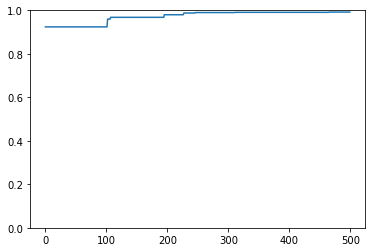

In [24]:
plt.figure()
plt.plot(abc.bestfi)
plt.ylim(0,1)
plt.show()